In [15]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import label, regionprops
from google.colab import drive
from PIL import Image
import io

In [48]:
from google.colab import files
uploaded = files.upload()



images = []
valid_filenames = []

for name, file in uploaded.items():
    try:
        img = Image.open(io.BytesIO(file)).convert("RGB")
        img_np = np.array(img)
        images.append(img_np)
        valid_filenames.append(name)
    except Exception as e:
        print(f"Gagal membaca file {name}: {e}")

Saving CL-S-013.jpg to CL-S-013.jpg


In [49]:
#Ekstraksi Fitur Warna (HSV)

def extract_color_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    H, S, V = cv2.split(hsv)
    return [np.mean(H), np.std(H), np.mean(S), np.std(S), np.mean(V), np.std(V)]

In [50]:
#Ekstraksi Fitur Tekstur (GLCM)

def extract_texture_features(image):
    gray = rgb2gray(image)
    gray = (gray * 255).astype(np.uint8)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    return [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'dissimilarity')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0]
    ]

In [51]:
#Ekstraksi Fitur Bentuk (Shape)

def extract_shape_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    label_img = label(thresh)
    props = regionprops(label_img)
    if props:
        largest_region = max(props, key=lambda x: x.area)
        area = largest_region.area
        perimeter = largest_region.perimeter if largest_region.perimeter != 0 else 1
        circularity = 4 * np.pi * area / (perimeter ** 2)
    else:
        area, perimeter, circularity = 0, 0, 0
    return [area, perimeter, circularity]


In [52]:
def extract_all_features(image):
    return extract_color_features(image) + extract_texture_features(image) + extract_shape_features(image)

In [53]:
#Ekstraksi Fitur ke Gambar

feature_list = []
for img, fname in zip(images, valid_filenames):
    features = extract_all_features(img)
    feature_list.append([fname] + features)

In [54]:
headers = ['filename',
           'mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V',
           'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation',
           'area', 'perimeter', 'circularity']

df = pd.DataFrame(feature_list, columns=headers)
df.to_csv('extracted_features_daun_obat.csv', index=False)
print("✅ Ekstraksi fitur selesai")

# Tampilkan isi file di bawah ini
df_preview = pd.read_csv('extracted_features_daun_obat.csv')
df_preview.head()

✅ Ekstraksi fitur selesai


,filename,mean_H,std_H,mean_S,std_S,mean_V,std_V,contrast,dissimilarity,homogeneity,energy,correlation,area,perimeter,circularity
0,CL-S-013.jpg,13.717291,17.657824,53.546606,67.6307,188.796539,81.731341,19.371888,0.798529,0.794709,0.589929,0.998635,1157870.0,9130.749709,0.174525


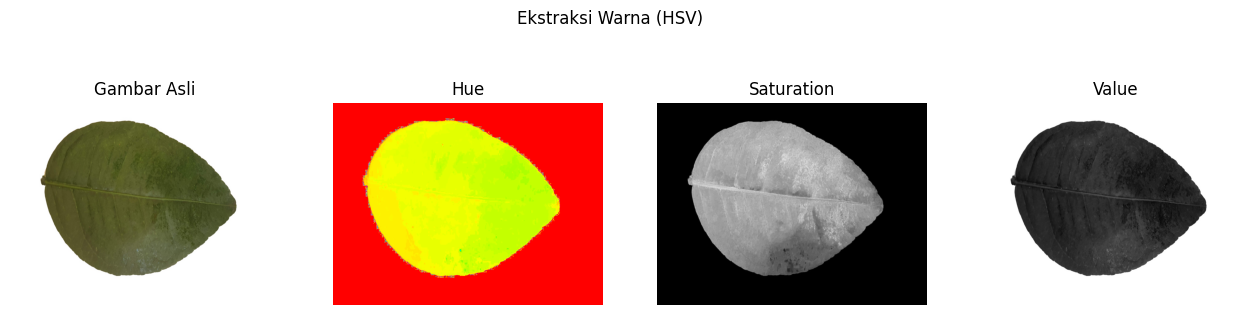

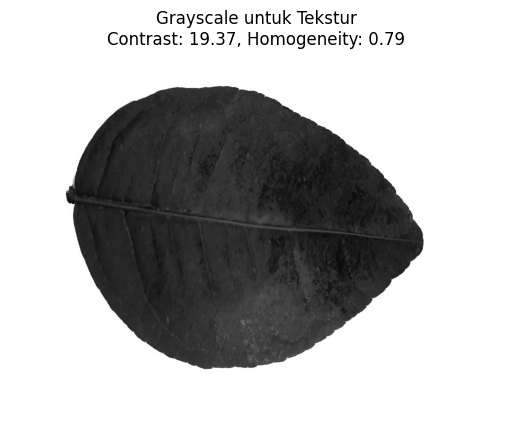

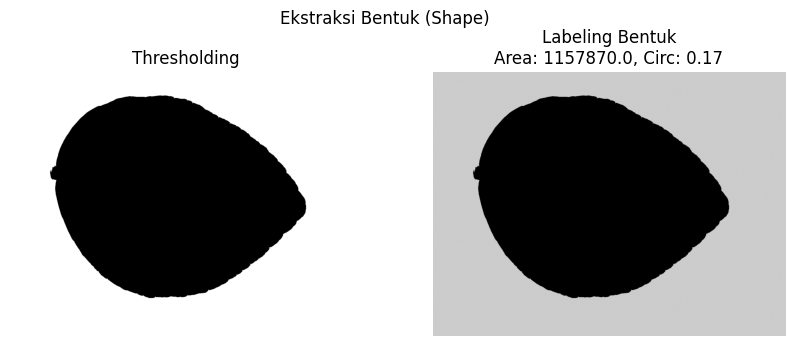

In [55]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import label, regionprops
import cv2
import numpy as np

# Ambil 1 sample image
img = images[0]
filename = valid_filenames[0]

# 1. Warna (HSV)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
H, S, V = cv2.split(hsv)

# Tampilkan komponen HSV
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(img)
axs[0].set_title('Gambar Asli')
axs[1].imshow(H, cmap='hsv')
axs[1].set_title('Hue')
axs[2].imshow(S, cmap='gray')
axs[2].set_title('Saturation')
axs[3].imshow(V, cmap='gray')
axs[3].set_title('Value')
for ax in axs: ax.axis('off')
plt.suptitle("Ekstraksi Warna (HSV)")
plt.show()

# 2. Tekstur (GLCM)
gray = rgb2gray(img)
gray_u8 = (gray * 255).astype(np.uint8)

glcm = graycomatrix(gray_u8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
contrast = graycoprops(glcm, 'contrast')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

plt.imshow(gray_u8, cmap='gray')
plt.title(f"Grayscale untuk Tekstur\nContrast: {contrast:.2f}, Homogeneity: {homogeneity:.2f}")
plt.axis('off')
plt.show()

# 3. Bentuk (Shape)
gray_shape = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
_, thresh = cv2.threshold(gray_shape, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
label_img = label(thresh)
props = regionprops(label_img)

if props:
    region = max(props, key=lambda x: x.area)
    area = region.area
    perimeter = region.perimeter
    circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
else:
    area = perimeter = circularity = 0

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(thresh, cmap='gray')
axs[0].set_title("Thresholding")
axs[1].imshow(label_img, cmap='nipy_spectral')
axs[1].set_title(f"Labeling Bentuk\nArea: {area}, Circ: {circularity:.2f}")
for ax in axs: ax.axis('off')
plt.suptitle("Ekstraksi Bentuk (Shape)")
plt.show()